In [3]:
import pandas as pd
import numpy as np

In [4]:
from datetime import datetime
from flask import Flask, redirect, render_template, request, url_for, send_file
import re
import csv
import h5py
import matplotlib.pyplot as plt
import time
import string

In [5]:
# from tensorflow.keras.models import model_from_json
# from tensorflow.keras.preprocessing.text import Tokenizer
# import pickle
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import load_model

In [6]:
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix

WNL = nltk.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankitasharma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ankitasharma/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [7]:
pd.options.display.max_colwidth = 1000

In [8]:
clinnotes = pd.read_csv("ClinNotes.csv")

In [9]:
clinnotes.head()

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericardial effusion.,6. Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7. PA systolic pressure is 36 mmHg.,DOPPLER: , ,1. Mild mitral and tricuspid regurgitation.,2. Trace aortic and pulmonary regurgitation."
1,Cardiovascular / Pulmonary,"1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function. There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2. The left atrium appears mildly dilated.,3. The right atrium and right ventricle appear normal.,4. The aortic root appears normal.,5. The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6. There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart and great vessels reveal normal intracardiac and great vessel relationships. Cardiac function is normal. There is no significant chamber enlargement or hypertrophy. There is no pericardial effusion or vegetations seen. Doppler interrogation, including color flow imaging, reveals systemic venous return to the right atrium with normal tricuspid inflow. Pulmonary outflow is normal at the valve. Pulmonary venous return is to the left atrium. The interatrial septum is intact. Mitral inflow and ascending aorta flow are normal. The aortic valve is trileaflet. The coronary arteries appear to be normal in their origins. The aortic arch is left-sided and patent with normal descending aorta pulsatility."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size.,2. Normal left ventricular size.,3. Normal LV systolic function. Ejection fraction estimated around 60%.,4. Aortic valve seen with good motion.,5. Mitral valve seen with good motion.,6. Tricuspid valve seen with good motion.,7. No pericardial effusion or intracardiac masses.,DOPPLER:,1. Trace mitral regurgitation.,2. Trace tricuspid regurgitation.,IMPRESSION:,1. Normal LV systolic function.,2. Ejection fraction estimated around 60%.,"
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calcified, minimally restricted.,2. Mild left ventricular hypertrophy but normal systolic function.,3. Moderate biatrial enlargement.,4. Normal right ventricle.,5. Normal appearance of the tricuspid and mitral valves.,6. Normal left ventricle and left ventricular systolic function.,DOPPLER,1. There is 1 to 2+ aortic regurgitation easily seen, but no aortic stenosis.,2. Mild tricuspid regurgitation with only mild increase in right heart pressures, 30-35 mmHg maximum.,SUMMARY,1. Normal left ventricle.,2. Moderate biatrial enlargement.,3. Mild tricuspid regurgitation, but only mild increase in right heart pressures."


In [10]:
clinnotes['category'].value_counts()

Cardiovascular / Pulmonary    371
Gastroenterology              224
Neurology                     223
Name: category, dtype: int64

In [11]:
medconcepts = pd.read_csv("MedicalConcepts.csv")

In [12]:
medconcepts.shape

(566, 2)

In [13]:
medconcepts.head(30)

,Term1,Term2
0,Glaucoma,Fibrillation
1,Carbatrol,Dilantin
2,Cardiomyopathy,Tylenol
3,Herpes,Hyperthyroidism
4,Seasickness,Nausea
5,Coccidioidomycosis,Histoplasmosis
6,Angina,Plavix
7,Zofran,Ipecac Syrup
8,Seizures,Insulin
9,Septicemia,Dyspnea


In [14]:
medconcepts['Term1'].value_counts()

Dyslipidemia             8
Fibrillation             8
Mycosis                  8
Dyspnea                  7
Cataracts                7
                        ..
Emaciation               1
Cardialgia               1
Iron                     1
Bacteremia               1
Abortions.spontaneous    1
Name: Term1, Length: 269, dtype: int64

#### Data Cleaning

In [15]:
nltk.download('words')
words = set(nltk.corpus.words.words())
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package words to
[nltk_data]     /Users/ankitasharma/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitasharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def data_cleaning(df, stopwords_list):
    col = 'notes'
    df[col] = df[col].str.replace('[^\w\s]','')
    df[col] = df[col].str.replace('\d+', '')
    df[col] = df[col].str.replace('?', ' ')
    df[col] = df[col].str.replace('\W+', ' ')
    df[col] = df[col].str.replace(',', ' ')
    df[col] = df[col].str.replace('.', ' ')
    df[col] = df[col].str.replace('/', ' ')
    df[col] = df[col].str.replace('-', ' ')
    df[col] = df[col].str.replace('#', ' ')
    df[col] = df[col].str.replace('@', ' ')
    df[col] = df[col].str.replace(':', ' ')
    df[col] = df[col].str.replace('_', ' ')
    df[col] = df[col].str.lower().apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
    df[col] = df[col].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    df[col] = df[col].str.replace('   ', ' ')
    df[col] = df[col].str.replace('  ', ' ')
    df[col] = df[col].str.rstrip()
    df[col] = df[col].str.lstrip()
    print("data.head from cleaned function---------------------")
    print(df.head())
    return df


In [17]:
stop_words = stopwords.words('english')

stop_words.extend([])


In [18]:
df_new = clinnotes[['notes', 'category']]

In [19]:
df_new.isna().sum()

notes       0
category    0
dtype: int64

In [20]:
data_cleaning(df_new, stop_words)

/var/folders/vc/zzf9shx92r95f9pzdwngyskc0000gn/T/ipykernel_1061/3586559313.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('[^\w\s]','')
/var/folders/vc/zzf9shx92r95f9pzdwngyskc0000gn/T/ipykernel_1061/3586559313.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\d+', '')
/var/folders/vc/zzf9shx92r95f9pzdwngyskc0000gn/T/ipykernel_1061/3586559313.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('?', ' ')
/var/folders/vc/zzf9shx92r95f9pzdwngyskc0000gn/T/ipykernel_1061/3586559313.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\W+', ' ')
/var/folders/vc/z

data.head from cleaned function---------------------
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

,notes,category
0,left atrial enlargement left atrial diameter normal size right left ventricle normal systolic function left ventricular ejection fraction normal diastolic function pericardial effusion normal morphology aortic valve mitral valve tricuspid valve pulmonary valve pa systolic pressure mild mitral tricuspid regurgitation trace aortic pulmonary regurgitation,Cardiovascular / Pulmonary
1,left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function ejection fraction obliteration seen also left ventricular outflow tract gradient mid cavity level consistent left ventricular systolic function abnormal left ventricular relaxation pattern seen well elevated left atrial seen examination left atrium mildly dilated right atrium right ventricle appear normal aortic root normal aortic valve calcified mild aortic valve stenosis calculated aortic valve area square maximum instantaneous gradient mean gradient mitral annular calcification extending supportive thickening mitral valve mild mitral regurgitation tricuspid valve normal trace tricuspid regurgitation moderate pulmonary artery hypertension pulmonary artery systolic pressure right atrial pressure pulmonary valve normal trace pulmonary insufficiency pericardial effusion intracardiac mass seen color suggestive patent foramen lipomatous hypertrophy interatrial septum study somewhat...,Cardiovascular / Pulmonary
2,heart great reveal normal intracardiac great vessel cardiac function normal significant chamber enlargement hypertrophy pericardial effusion seen interrogation color flow systemic venous return right atrium normal tricuspid inflow pulmonary outflow normal valve pulmonary venous return left atrium interatrial septum intact mitral inflow ascending aorta flow normal aortic valve coronary appear normal aortic arch patent normal descending aorta pulsatility,Cardiovascular / Pulmonary
3,description normal cardiac size normal left ventricular size normal systolic function ejection fraction around aortic valve seen good motion mitral valve seen good motion tricuspid valve seen good motion pericardial effusion intracardiac trace mitral regurgitation trace tricuspid normal systolic function ejection fraction around,Cardiovascular / Pulmonary
4,study mild aortic stenosis widely calcified minimally restricted mild left ventricular hypertrophy normal systolic function moderate enlargement normal right ventricle normal appearance tricuspid mitral normal left ventricle left ventricular systolic aortic regurgitation easily seen aortic stenosis mild tricuspid regurgitation mild increase right heart normal left ventricle moderate enlargement mild tricuspid regurgitation mild increase right heart,Cardiovascular / Pulmonary
...,...,...
813,indication chest test adenosine nuclear scan patient unable walk resting heart rate blood pressure normal sinus rhythm heart rate blood pressure adenosine stress test nuclear interpretation interpretation resting stress intravenously standard protocol nuclear myocardial perfusion scan homogeneous uniform distribution tracer uptake without evidence reversible fixed defect gated revealed normal wall motion ejection fraction volume volume impression normal nuclear myocardial perfusion scan ejection fraction gated,Cardiovascular / Pulmonary
814,chief complaint chest present illness patient white male chief complaint chest patient diabetic prior history coronary artery disease patient today chest pain yesterday evening somewhat intermittent severity pain progressively pain sharp heavy pain neck left arm pain scale shortness breath diaphoresis nausea vomiting tonight fever prior similar pain prior pain somewhat worse walking relieved rest change pain took nitroglycerin past hour partially relieved pain patient present pain scale recent episode pain patient history recent surgery head trauma recent stroke abnormal bleeding blood urine stool medical history diabetes type hypertension coronary artery disease atrial f

In [ ]:
def remove_stop_words(df, target_col, new_col):
    df[new_col] = df[target_col].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords.words('english')]))
    return df

def remove_punctuations(df, target_col, new_col):
    df[new_col] = df[target_col].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    return df



df_new = remove_stop_words(df_new, 'notes', 'notes_stop')
df_new = remove_punctuations(df_new, 'notes_stop', 'notes_punc')

##### Lemmatize and Tokenize

In [21]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

lemmatizer = nltk.stem.WordNetLemmatizer()

In [22]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankitasharma/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [24]:
df_new['notes_lemmatized'] = df_new.notes.apply(lemmatize_text)

In [25]:
df_new.head(20)

,notes,category,notes_lemmatized
0,left atrial enlargement left atrial diameter normal size right left ventricle normal systolic function left ventricular ejection fraction normal diastolic function pericardial effusion normal morphology aortic valve mitral valve tricuspid valve pulmonary valve pa systolic pressure mild mitral tricuspid regurgitation trace aortic pulmonary regurgitation,Cardiovascular / Pulmonary,"[left, atrial, enlargement, left, atrial, diameter, normal, size, right, left, ventricle, normal, systolic, function, left, ventricular, ejection, fraction, normal, diastolic, function, pericardial, effusion, normal, morphology, aortic, valve, mitral, valve, tricuspid, valve, pulmonary, valve, pa, systolic, pressure, mild, mitral, tricuspid, regurgitation, trace, aortic, pulmonary, regurgitation]"
1,left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function ejection fraction obliteration seen also left ventricular outflow tract gradient mid cavity level consistent left ventricular systolic function abnormal left ventricular relaxation pattern seen well elevated left atrial seen examination left atrium mildly dilated right atrium right ventricle appear normal aortic root normal aortic valve calcified mild aortic valve stenosis calculated aortic valve area square maximum instantaneous gradient mean gradient mitral annular calcification extending supportive thickening mitral valve mild mitral regurgitation tricuspid valve normal trace tricuspid regurgitation moderate pulmonary artery hypertension pulmonary artery systolic pressure right atrial pressure pulmonary valve normal trace pulmonary insufficiency pericardial effusion intracardiac mass seen color suggestive patent foramen lipomatous hypertrophy interatrial septum study somewhat...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickness, appear, normal, wall, motion, left, ventricular, systolic, function, ejection, fraction, obliteration, seen, also, left, ventricular, outflow, tract, gradient, mid, cavity, level, consistent, left, ventricular, systolic, function, abnormal, left, ventricular, relaxation, pattern, seen, well, elevated, left, atrial, seen, examination, left, atrium, mildly, dilated, right, atrium, right, ventricle, appear, normal, aortic, root, normal, aortic, valve, calcified, mild, aortic, valve, stenosis, calculated, aortic, valve, area, square, maximum, instantaneous, gradient, mean, gradient, mitral, annular, calcification, extending, supportive, thickening, mitral, valve, mild, mitral, regurgitation, tricuspid, valve, normal, trace, tricuspid, regurgitation, moderate, pulmonary, artery, hypertension, pulmonary, artery, systolic, pressure, right, ...]"
2,heart great reveal normal intracardiac great vessel cardiac function normal significant chamber enlargement hypertrophy pericardial effusion seen interrogation color flow systemic venous return right atrium normal tricuspid inflow pulmonary outflow normal valve pulmonary venous return left atrium interatrial septum intact mitral inflow ascending aorta flow normal aortic valve coronary appear normal aortic arch patent normal descending aorta pulsatility,Cardiovascular / Pulmonary,"[heart, great, reveal, normal, intracardiac, great, vessel, cardiac, function, normal, significant, chamber, enlargement, hypertrophy, pericardial, effusion, seen, interrogation, color, flow, systemic, venous, return, right, atrium, normal, tricuspid, inflow, pulmonary, outflow, normal, valve, pulmonary, venous, return, left, atrium, interatrial, septum, intact, mitral, inflow, ascending, aorta, flow, normal, aortic, valve, coronary, appear, normal, aortic, arch, patent, normal, descending, aorta, pulsatility]"
3,description normal cardiac size normal left ventricular size normal systolic function ejection fraction around aortic valve seen good motion mitral valve seen good motion tricuspid valve seen good motion pericardial effusion intracardiac trace

### Word embeddings

##### CountVectorizer

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_new["notes"])
print(vectorizer.get_feature_names())
print(X.toarray())

['abandoned', 'abdomen', 'abdominal', 'abduction', 'abductor', 'aberrant', 'ability', 'ablation', 'able', 'abnormal', 'abnormality', 'abnormally', 'abort', 'aborted', 'abortion', 'abortive', 'abrasion', 'abrupt', 'abruptly', 'abscess', 'absence', 'absent', 'absolute', 'absolutely', 'absorbable', 'abstain', 'abstract', 'abundant', 'abundantly', 'abuse', 'abut', 'abutting', 'academic', 'accelerated', 'acceleration', 'accept', 'acceptable', 'accepted', 'access', 'accessory', 'accident', 'accidental', 'accommodate', 'accommodation', 'accomplish', 'accomplished', 'according', 'accordingly', 'account', 'accounting', 'accumulation', 'accuracy', 'accurate', 'accurately', 'ace', 'acetabular', 'acetic', 'acetylcholine', 'achalasia', 'ache', 'achieve', 'achievement', 'aching', 'achy', 'acid', 'acidosis', 'acknowledged', 'acne', 'acoustic', 'acquired', 'acquisition', 'across', 'acrylic', 'act', 'acting', 'action', 'activation', 'active', 'actively', 'activity', 'actual', 'actually', 'acuity', 'acu

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
print(X.toarray()[-1])

[0 1 1 ... 0 0 0]


##### Transfer learning with word2vec using google news data

In [28]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors

pretrained_path = "googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin"

Word2VecModel = KeyedVectors.load_word2vec_format(pretrained_path, binary = True, limit = 100000)


In [29]:
print(Word2VecModel.most_similar('good'))

[('great', 0.7291510105133057), ('bad', 0.7190050482749939), ('terrific', 0.6889114379882812), ('decent', 0.6837348937988281), ('nice', 0.6836092472076416), ('excellent', 0.6442928910255432), ('fantastic', 0.6407778263092041), ('better', 0.6120728850364685), ('solid', 0.5806034803390503), ('lousy', 0.5764201879501343)]


In [30]:
# build base model from current dataset:
base_model = Word2Vec(vector_size=300, min_count=10)
base_model.build_vocab(df_new["notes_lemmatized"])
total_examples = base_model.corpus_count
base_model_exp = base_model.wv

In [31]:
base_model_exp.most_similar("atrial")

[('gated', 0.1908111572265625),
 ('chemotherapy', 0.1768842190504074),
 ('drop', 0.17264188826084137),
 ('cystic', 0.17171528935432434),
 ('carried', 0.16174466907978058),
 ('exercise', 0.16105154156684875),
 ('dominant', 0.15816302597522736),
 ('patent', 0.15681572258472443),
 ('connected', 0.1559729129076004),
 ('red', 0.1547064632177353)]

In [32]:
# Add new data weights and retrain
base_model.build_vocab([list(Word2VecModel.key_to_index.keys())], update=True)

# train on your data
base_model.train(df_new["notes_lemmatized"], total_examples=total_examples, epochs=base_model.epochs)
base_model_wv = base_model.wv

In [33]:
base_model_wv.most_similar("atrial")

[('heart', 0.9566921591758728),
 ('fibrillation', 0.9413415789604187),
 ('murmur', 0.9110031723976135),
 ('sinus', 0.9076511859893799),
 ('congestive', 0.9059546589851379),
 ('rhythm', 0.9050491452217102),
 ('function', 0.8972355723381042),
 ('positive', 0.8910911679267883),
 ('failure', 0.8788502812385559),
 ('stress', 0.8770595192909241)]

In [34]:
base_model_wv.most_similar("bronchoscopy")

[('operation', 0.9969238638877869),
 ('preoperatively', 0.9950141906738281),
 ('proceed', 0.9919703006744385),
 ('frozen', 0.9918301701545715),
 ('endoscopy', 0.9917302131652832),
 ('alternative', 0.9901415109634399),
 ('perforation', 0.9895642399787903),
 ('death', 0.9891202449798584),
 ('intravenous', 0.9878605604171753),
 ('potential', 0.9877817034721375)]

In [35]:
base_model_wv.most_similar("liver")


[('bladder', 0.995324432849884),
 ('abnormal', 0.9935150742530823),
 ('old', 0.9927641749382019),
 ('inflammatory', 0.9923035502433777),
 ('hydrocephalus', 0.9915333390235901),
 ('bleed', 0.9914947748184204),
 ('neuropathy', 0.9913244843482971),
 ('question', 0.99122154712677),
 ('progression', 0.9912179112434387),
 ('dysfunction', 0.9909852147102356)]

In [36]:
#One can already notice better embeddings with repect to similar words to a term like "atrial"
#Now that pre trained embedding from google news has been used, the model is doing better at english 

##### T-SNE visualization

In [37]:
from gensim.models import Word2Vec    #Import gensim Word2Fec
from sklearn.decomposition import PCA #Grab PCA functions

#Plot helpers
import matplotlib
import matplotlib.pyplot as plt
#Enable matplotlib to be interactive (zoom etc)
%matplotlib notebook

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [83]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.key_to_index:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



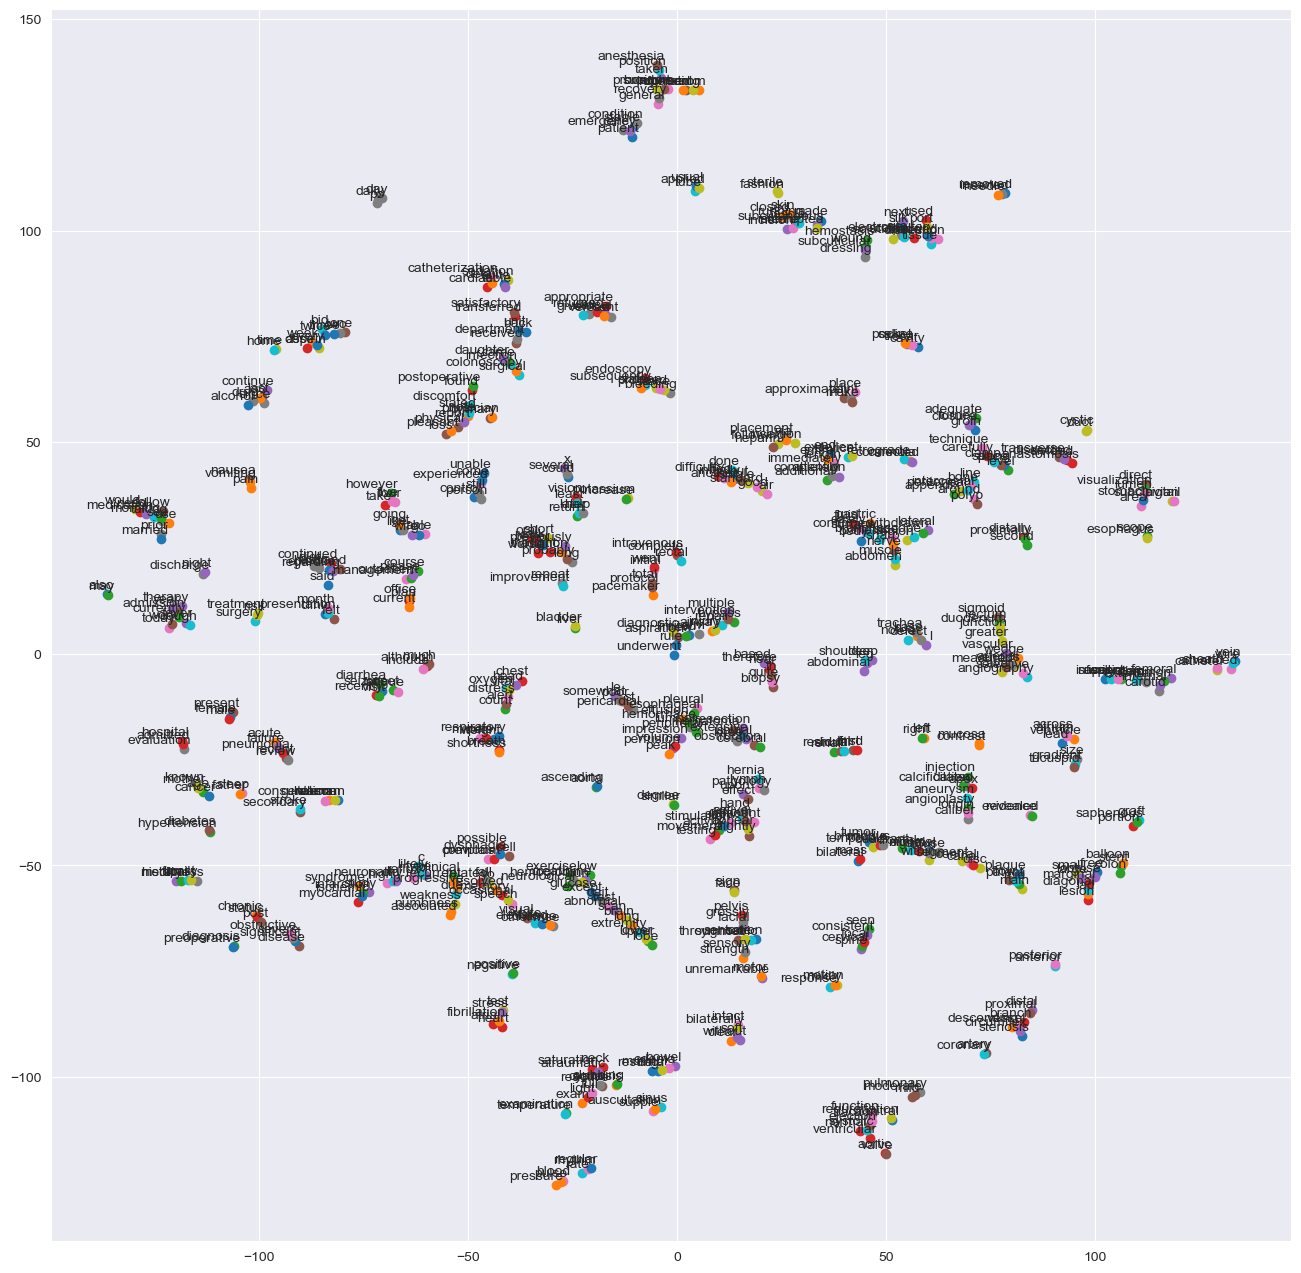

In [75]:
tsne_plot(base_model_wv)


In [95]:
df_new.head(10)

,notes,category,notes_lemmatized
0,left atrial enlargement left atrial diameter normal size right left ventricle normal systolic function left ventricular ejection fraction normal diastolic function pericardial effusion normal morphology aortic valve mitral valve tricuspid valve pulmonary valve pa systolic pressure mild mitral tricuspid regurgitation trace aortic pulmonary regurgitation,Cardiovascular / Pulmonary,"[left, atrial, enlargement, left, atrial, diameter, normal, size, right, left, ventricle, normal, systolic, function, left, ventricular, ejection, fraction, normal, diastolic, function, pericardial, effusion, normal, morphology, aortic, valve, mitral, valve, tricuspid, valve, pulmonary, valve, pa, systolic, pressure, mild, mitral, tricuspid, regurgitation, trace, aortic, pulmonary, regurgitation]"
1,left ventricular cavity size wall thickness appear normal wall motion left ventricular systolic function ejection fraction obliteration seen also left ventricular outflow tract gradient mid cavity level consistent left ventricular systolic function abnormal left ventricular relaxation pattern seen well elevated left atrial seen examination left atrium mildly dilated right atrium right ventricle appear normal aortic root normal aortic valve calcified mild aortic valve stenosis calculated aortic valve area square maximum instantaneous gradient mean gradient mitral annular calcification extending supportive thickening mitral valve mild mitral regurgitation tricuspid valve normal trace tricuspid regurgitation moderate pulmonary artery hypertension pulmonary artery systolic pressure right atrial pressure pulmonary valve normal trace pulmonary insufficiency pericardial effusion intracardiac mass seen color suggestive patent foramen lipomatous hypertrophy interatrial septum study somewhat...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickness, appear, normal, wall, motion, left, ventricular, systolic, function, ejection, fraction, obliteration, seen, also, left, ventricular, outflow, tract, gradient, mid, cavity, level, consistent, left, ventricular, systolic, function, abnormal, left, ventricular, relaxation, pattern, seen, well, elevated, left, atrial, seen, examination, left, atrium, mildly, dilated, right, atrium, right, ventricle, appear, normal, aortic, root, normal, aortic, valve, calcified, mild, aortic, valve, stenosis, calculated, aortic, valve, area, square, maximum, instantaneous, gradient, mean, gradient, mitral, annular, calcification, extending, supportive, thickening, mitral, valve, mild, mitral, regurgitation, tricuspid, valve, normal, trace, tricuspid, regurgitation, moderate, pulmonary, artery, hypertension, pulmonary, artery, systolic, pressure, right, ...]"
2,heart great reveal normal intracardiac great vessel cardiac function normal significant chamber enlargement hypertrophy pericardial effusion seen interrogation color flow systemic venous return right atrium normal tricuspid inflow pulmonary outflow normal valve pulmonary venous return left atrium interatrial septum intact mitral inflow ascending aorta flow normal aortic valve coronary appear normal aortic arch patent normal descending aorta pulsatility,Cardiovascular / Pulmonary,"[heart, great, reveal, normal, intracardiac, great, vessel, cardiac, function, normal, significant, chamber, enlargement, hypertrophy, pericardial, effusion, seen, interrogation, color, flow, systemic, venous, return, right, atrium, normal, tricuspid, inflow, pulmonary, outflow, normal, valve, pulmonary, venous, return, left, atrium, interatrial, septum, intact, mitral, inflow, ascending, aorta, flow, normal, aortic, valve, coronary, appear, normal, aortic, arch, patent, normal, descending, aorta, pulsatility]"
3,description normal cardiac size normal left ventricular size normal systolic function ejection fraction around aortic valve seen good motion mitral valve seen good motion tricuspid valve seen good motion pericardial effusion intracardiac trace

In [107]:
keys = ["atrial", 'ventricular', 'heart', 'patient', 'preoperative', 'neuropathy']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in base_model_wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(base_model_wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [108]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

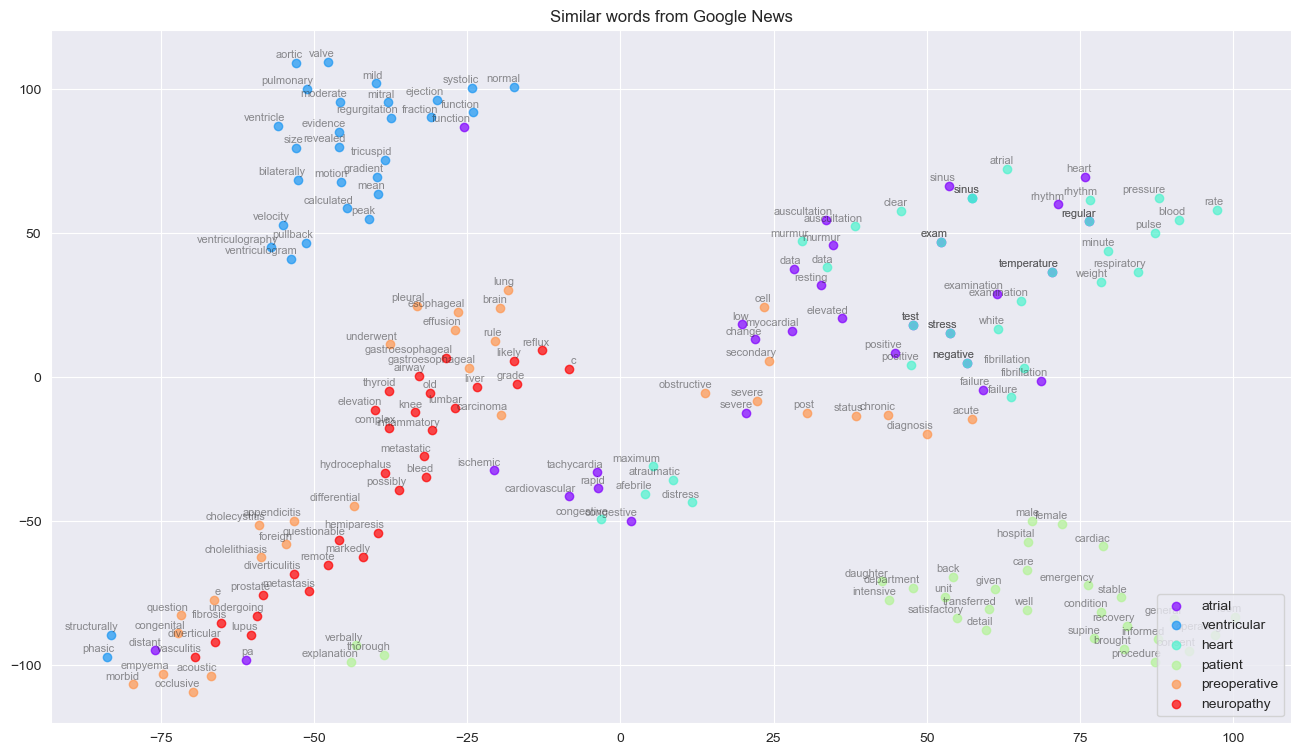

In [110]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [ ]:
tsne_visualize(base_model_wv, labels)

##### Word embedding pre trained on published clinical case reports:

In [45]:
from transformers import AutoTokenizer, AutoModel

In [47]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [56]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 1142, 1110, 170, 1129, 3740, 2235, 17463, 2916, 102, 0], [101, 1195, 1209, 2503, 118, 9253, 170, 1129, 3740, 2235, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [76]:
tokens = tokenizer.batch_encode_plus(
    df_new['notes_punc'].tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [94]:
tokens['input_ids']

[[101,
  1286,
  1120,
  13119,
  4035,
  5815,
  20512,
  1286,
  1120,
  13119,
  6211,
  2999,
  2060,
  1268,
  1286,
  21828,
  4907,
  1513,
  2999,
  188,
  6834,
  2430,
  8031,
  3053,
  102],
 [101,
  1286,
  21828,
  4907,
  5552,
  19421,
  2060,
  2095,
  15830,
  2845,
  2999,
  2095,
  4018,
  1286,
  21828,
  4907,
  5552,
  188,
  6834,
  2430,
  8031,
  3053,
  174,
  26857,
  102],
 [101,
  1762,
  1632,
  7063,
  2999,
  1107,
  4487,
  10542,
  12571,
  1632,
  5832,
  17688,
  3053,
  2999,
  2418,
  5383,
  4035,
  5815,
  20512,
  177,
  24312,
  8005,
  22192,
  1679,
  102],
 [101,
  6136,
  2999,
  17688,
  2060,
  2999,
  1286,
  21828,
  4907,
  5552,
  2060,
  2999,
  188,
  6834,
  2430,
  8031,
  3053,
  174,
  26857,
  13394,
  1213,
  170,
  12148,
  1596,
  102],
 [101,
  2025,
  10496,
  170,
  12148,
  1596,
  188,
  5208,
  11776,
  3409,
  11019,
  1233,
  6617,
  8971,
  10298,
  1193,
  7458,
  10496,
  1286,
  21828,
  4907,
  5552,
  177,
  24

In [88]:
list(tokenizer.vocab.keys())[1000:1020]

['##losure',
 '##roll',
 'flows',
 'paired',
 'Sometimes',
 '##rge',
 'Jaya',
 'Springs',
 'vodka',
 '##ax',
 '##়',
 'granite',
 'ancestors',
 'Broadcast',
 'Freiburg',
 'readers',
 'specifications',
 'Bernard',
 'Technology',
 'modification']

In [95]:
tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens['input_ids'])

/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ankitasharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [109]:
# tokenizer.save_vocabulary(vocab_path='.')

In [99]:
wordembs = model.get_input_embeddings()

In [101]:
model.config.vocab_size

28996

In [102]:
# Convert the vocabulary embeddings to numpy.
allinds = np.arange(0,model.config.vocab_size,1)
inputinds = torch.LongTensor(allinds)
bertwordembs = wordembs(inputinds).detach().numpy()

In [103]:
bertwordembs.shape

(28996, 768)

In [104]:
def loadLines(filename):
    print("Loading lines from file", filename)
    f = open(filename,'r')
    lines = np.array([])
    for line in f:
        lines = np.append(lines, line.rstrip())
    print("Done. ", len(lines)," lines loaded!")
    return lines

In [110]:
# bertwords = loadLines('vocab.txt')

In [75]:
# df_new.head()

##### LDA

In [40]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [93]:
dictionary = corpora.Dictionary(df_new["notes_lemmatized"])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in df_new["notes_lemmatized"]]

In [ ]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                chunksize=200, passes=100)

In [86]:
lda_model.save('model5.gensim')
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.048*"artery" + 0.042*"left" + 0.027*"right" + 0.019*"femoral"')
(1, '0.022*"patient" + 0.018*"history" + 0.010*"normal" + 0.010*"pain"')
(2, '0.022*"patient" + 0.014*"procedure" + 0.011*"right" + 0.009*"diagnosis"')


In [42]:
from gensim import corpora
dictionary = corpora.Dictionary(df_new["notes_lemmatized"])

In [43]:
corpus = [dictionary.doc2bow(text) for text in df_new["notes_lemmatized"]]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [111]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

ModuleNotFoundError: No module named 'pyLDAvis.gensim'